# Truncated Harmonic Mean Estimator (THAMES)

Metodiev et al. (2025), Bayesian Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
from jax.scipy.special import logsumexp, gammaln

import blackjax
import numpyro as npr
import numpyro.distributions as dist
import numpyro.distributions.transforms as nprb
import pandas as pd
import sys

import bamojax
from bamojax.base import Model
from bamojax.samplers import mcmc_sampler
from bamojax.inference import MCMCInference, SMCInference
from bamojax.marginal_likelihoods.utility import flatten_dict_to_array
from bamojax.marginal_likelihoods.bridge_sampling import bridge_sampling
from bamojax.marginal_likelihoods.thames import thames

print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Bamojax version:    ', bamojax.__version__)
print('Numpyro version:    ', npr.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Jax version:         0.7.2
BlackJax version:    1.2.5
Bamojax version:     0.3.10+4.gf6f1d99.dirty
Numpyro version:     0.19.0
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


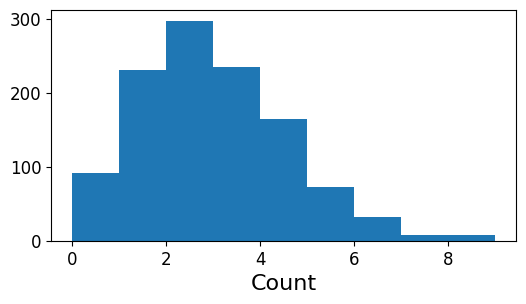

In [3]:
files = ['2005-06', '2006-07', '2007-08']
goals = []

for year in files:
    df = pd.read_csv(f'/scratch/big/home/maxhin/Documents/Code/Bayesian Model Comparison/data/English premiership/{year}.csv')  
    total_goals = df['FTHG'] + df['FTAG']
    total_goals_array = total_goals.to_numpy()
    goals.extend(total_goals_array)

Y = jnp.array(goals)
n = len(Y)
plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.hist(Y, bins=jnp.arange(0, 10, 1))
ax.set_xlabel('Goals')
ax.set_xlabel('Count');

In [18]:
def construct_negative_binomial_model(observations) -> Model:
    # Note: Hastie & Green, Wikipedia, and TFD all have their own parametrizations of the negative binomial
    def negbin_link_fn(rate, dispersion):
        p = rate / (rate + 1 / dispersion)
        r = 1 / dispersion
        return dict(probs=p, total_count=r)

    #

    model = Model('Negative binomial')
    rate_node = model.add_node('lam', distribution=dist.Gamma(concentration=25, rate=10)) 
    dispersion_node = model.add_node('kappa', distribution=dist.Gamma(concentration=1, rate=10))  
    _ = model.add_node('Y', observations=observations, parents=dict(rate=rate_node, dispersion=dispersion_node), distribution=dist.NegativeBinomialProbs, link_fn=negbin_link_fn)
    return model

#

model = construct_negative_binomial_model(Y)

In [5]:
%%time
N = 5_000
key = jrnd.PRNGKey(0)
key, subkey = jrnd.split(key)

m = model.get_model_size()
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(m))  # these will be overriden by the window adaptation
nuts_kernel = mcmc_sampler(model=model, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)

# we want to sample twice as many samples, since we need them for constructing the bridge density as well as for...
engine = MCMCInference(model=model, mcmc_kernel=nuts_kernel, num_samples=2*N, num_burn=0, num_warmup=1_000, num_thin=1)
results = engine.run(subkey)

posterior_samples = results['states']

Adapting NUTS HMC parameters... done.
CPU times: user 20.4 s, sys: 1.55 s, total: 21.9 s
Wall time: 8.98 s


Marginal likelihood should be somewhere around -2106.4

## THAMES

In [6]:
lml_thames = thames(jrnd.PRNGKey(0), model, posterior_samples)

print('THAMES estimator:', lml_thames)

THAMES estimator: -2106.369620990967


Compare with bridge sampling:

In [29]:
bridge_bijectors = dict(lam=nprb.ExpTransform(), kappa=nprb.ExpTransform())


lml_bs, _ = bridge_sampling(key=jrnd.PRNGKey(1),
                            model=model,
                            posterior_samples=posterior_samples, 
                            bijectors=bridge_bijectors, 
                            proposal_type='gaussian', N2=1000)

print('Bridge sampling estimate:', lml_bs)

Bridge sampling estimate: -2106.382331654749


## Eight schools data

To verify the approach works with different parameter shapes, let's try the log marginal likelihood estimators on the eight schools model:

In [37]:
means = jnp.array([28, 8, -3, 7, -1, 1, 18, 12])
stddevs = jnp.array([15, 10, 16, 11, 9, 11, 10, 18])

J = len(means)

ES = Model('eight schools')
mu = ES.add_node('mu', distribution=dist.Normal(loc=0, scale=10))
tau = ES.add_node('tau', distribution=dist.TransformedDistribution(dist.Normal(loc=5, scale=1), nprb.ExpTransform()))
theta = ES.add_node('theta', distribution=dist.Normal, parents=dict(loc=mu, scale=tau), shape=(J, ))
y = ES.add_node('y', distribution=dist.Normal, parents=dict(loc=theta, scale=stddevs), observations=means)

m = ES.get_model_size()
mcmc_params = dict(sigma=4.0*jnp.eye(m))
rmh_kernel = mcmc_sampler(ES, mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=mcmc_params)

num_particles = 5_000
num_mutations = 200
num_chains = 1

key = jrnd.PRNGKey(0)

engine = SMCInference(model=ES, num_chains=num_chains, mcmc_kernel=rmh_kernel, num_particles=num_particles, num_mutations=num_mutations)
result = engine.run(key)
ES_SMC_posterior_samples = result['final_state'].particles

print('SMC log marginal likelihood:', result['lml'])

SMC log marginal likelihood: -36.13476016390077


In [38]:
%%time
N = 5_000
key = jrnd.PRNGKey(0)
key, subkey = jrnd.split(key)

m = ES.get_model_size()
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(m))  # these will be overriden by the window adaptation
nuts_kernel = mcmc_sampler(model=ES, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)

# we want to sample twice as many samples, since we need them for constructing the bridge density as well as for...
engine = MCMCInference(model=ES, mcmc_kernel=nuts_kernel, num_samples=2*N, num_burn=0, num_warmup=1_000, num_thin=1)
results = engine.run(subkey)

ES_NUTS_posterior_samples = results['states']

Adapting NUTS HMC parameters... done.
CPU times: user 5.88 s, sys: 268 ms, total: 6.14 s
Wall time: 2.09 s


In [ ]:
print('Posterior samples using SMC:')

es_lml_thames = thames(jrnd.PRNGKey(1), model=ES, posterior_samples=ES_SMC_posterior_samples)

print('THAMES estimator:', es_lml_thames)

bridge_bijectors = dict(tau=nprb.ExpTransform())
es_lml_bs, _ = bridge_sampling(key=jrnd.PRNGKey(1),
                               model=ES,
                               posterior_samples=ES_SMC_posterior_samples, 
                               bijectors=bridge_bijectors, 
                               proposal_type='gaussian', N2=1000)

print('Bridge sampling estimate:', es_lml_bs)

print('Posterior samples using NUTS:')

es_lml_thames = thames(jrnd.PRNGKey(1), model=ES, posterior_samples=ES_NUTS_posterior_samples)

print('THAMES estimator:', es_lml_thames)

es_lml_bs, _ = bridge_sampling(key=jrnd.PRNGKey(1),
                               model=ES,
                               posterior_samples=ES_NUTS_posterior_samples, 
                               bijectors=bridge_bijectors, 
                               proposal_type='gaussian', N2=1000)

print('Bridge sampling estimate:', es_lml_bs)

Posterior samples using SMC:
THAMES estimator: -36.00558919799167
Bridge sampling estimate: -36.157942830761996
Posterior samples using NUTS:
THAMES estimator: -35.98432733521786
Bridge sampling estimate: -36.124341067462304


## Expectancy-valence model

Here, we compare the following log marginal likelihood estimators on the expectancy-valence model (see Steingroever et al., 2016; Gronau et al., 2017; Hinne, 2025 for more details):

- Importance sampling (Steingroever et al. implementation)
- Bridge sampling (Gronau et al. implementation)
- Bridge sampling (bamojax implementation)
- SMC (bamojax implementation)
- THAMES (bamojax implementation)

First, load data:

In [3]:
import pyreadr as pr
import requests

def download_to_disk(url, filepath):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filepath, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully!')
    else:
        print(f'Failed to download the file. Status code: {response.status_code}')

#
data_busemeyer_url = 'https://osf.io/download/5vws6/'  # DataBusemeyerNoNA.rdata on https://osf.io/f9cq4/; contains IGT data
data_busemeyer_file = 'DataBusemeyerNoNA.rdata'

data_steingroever_url = 'https://osf.io/download/bmnsv/'  # contains Steingroever's importance sampling marginal likelihoods
data_steingroever_file = 'DataSteingroever.rdata'

lml_url = 'https://osf.io/download/txnbs/' # ind_LogMargLik.txt on https://osf.io/f9cq4/; contains Gronau's bridge sampling estmates
lml_file = 'ind_LogMargLik.txt'

download_to_disk(data_busemeyer_url, data_busemeyer_file)
download_to_disk(data_steingroever_url, data_steingroever_file)
download_to_disk(lml_url, lml_file)

data_file = pr.read_r('DataBusemeyerNoNA.rdata')
choices = jnp.asarray(data_file['choice'].to_numpy().astype(int)) - 1  # Python zero-indexing
losses = jnp.asarray(data_file['lo'].to_numpy())
wins = jnp.asarray(data_file['wi'].to_numpy())

N, T = choices.shape
K = 4


File downloaded successfully!
File downloaded successfully!
File downloaded successfully!


Form bamojax model:

In [4]:
def ev_link_fn(w, a, c_raw, choices, wins, losses):
    c = 4*c_raw - 2.0
    ev = jnp.zeros((K, ))
    logits = jnp.ones((T, K))  # softmax of uniform is = [1/K, 1/K, ...]

    def for_body(t, carry):
        ev_, logits_ = carry
        theta = (0.1*(t+1))**c  
        current_utility = (1-w) * wins[t] + w*losses[t]
        k = choices[t]
        ev_ = ev_.at[k].add(a * (current_utility - ev_[k]))
        logits_ = logits_.at[t + 1, :].set(theta * ev_)
        return (ev_, logits_)
    
    #
    _, logits = jax.lax.fori_loop(0, T - 1, for_body, (ev, logits))

    return dict(logits=logits)

#
def make_ev_model(subject):
    EVModel = Model(f'Expectance valence model, subject {subject}')
    w_node = EVModel.add_node('w', distribution=dist.Beta(concentration0=1.0, concentration1=1.0))
    a_node = EVModel.add_node('a', distribution=dist.Beta(concentration0=1.0, concentration1=1.0))
    c_raw_node = EVModel.add_node('c_raw', distribution=dist.Beta(concentration0=1.0, concentration1=1.0))
    wins_node = EVModel.add_node('wins', observations=wins[subject, :])
    loss_node = EVModel.add_node('losses', observations=losses[subject, :])

    # Note that in RL examples we often have a form of autoregression. Here, `choices` are observed, but also feed back into the model.
    choice_node = EVModel.add_node('choices', 
                                observations=choices[subject, :], 
                                distribution=dist.Categorical, 
                                link_fn=ev_link_fn, 
                                parents=dict(w=w_node, 
                                                a=a_node, 
                                                c_raw=c_raw_node, 
                                                choices=choices[subject,:], 
                                                wins=wins_node, 
                                                losses=loss_node))
    return EVModel

#

Run inference for all subjects, here we use SMC

In [5]:
%%time
def wrapper(key, subject):
    evmodel = make_ev_model(subject=subject)
    mcmc_params = dict(sigma=stepsize*jnp.eye(evmodel.get_model_size()))
    mcmc = mcmc_sampler(evmodel, mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=mcmc_params)
    engine = SMCInference(model=evmodel, mcmc_kernel=mcmc, num_particles=num_particles, num_mutations=num_mcmc_steps, num_chains=num_chains)
    result = engine.run(key)
    return result

#
num_chains = 1
num_mcmc_steps = 100
num_particles = 1000
stepsize = 0.01

subjects = jnp.arange(N)
key = jrnd.PRNGKey(42)
keys = jrnd.split(key, N)
smc_fits = jax.vmap(wrapper)(keys, subjects)


CPU times: user 35.6 s, sys: 9.51 s, total: 45.1 s
Wall time: 40.4 s


In [ ]:
print('Posterior samples using SMC:')

key = jrnd.PRNGKey(0)
key, subkey = jrnd.split(key)
smc_thames_keys = jrnd.split(key, N)

def thames_wrapper(key, subject, posterior_samples):
    evmodel = make_ev_model(subject=subject)
    return thames(key, model=evmodel, posterior_samples=posterior_samples)

#
ev_lml_thames = jax.vmap(thames_wrapper)(smc_thames_keys, subjects, posterior_samples=smc_fits['final_state'].particles)
print('THAMES estimator:', ev_lml_thames)

Posterior samples using SMC:
THAMES estimator: [-130.27733121 -104.76012925 -115.44883197 -117.90032783 -104.43759616
 -137.11821349 -137.5729163  -129.95182013 -141.84123378  -89.40115296
 -133.42440438 -141.11109241 -140.39347713 -133.05980557 -133.35433378
 -137.28686024 -136.13324586 -109.51661239 -106.59221755 -141.24126
 -140.59201871 -109.71502738 -118.92695418 -138.32917349 -131.29963943
 -122.18857286 -125.19819512 -140.99577242 -138.12338629 -128.24655851]


In [18]:
import numpyro.distributions.constraints as constraints
from numpyro.distributions.transforms import Transform

class ProbitTransform(Transform):

    def __init__(self, domain=constraints.real):
        self.domain = domain
        self.codomain = constraints.unit_interval

    #
    def __call__(self, x):
        # forward: R -> (0,1)
        return 0.5 * (1.0 + jax.lax.erf(x / jnp.sqrt(2.0)))

    #
    def _inverse(self, y):
        # inverse: (0,1) -> R  (clipped for numerical stability)
        return jnp.sqrt(2.0) * jax.scipy.special.erfinv(2.0 * y - 1.0)

    #
    def log_abs_det_jacobian(self, x, y, intermediates=None):
        # log |dΦ/dx| = log φ(x) = -0.5 x^2 - 0.5 log(2π)
        return -0.5 * x**2 - 0.5 * jnp.log(2.0 * jnp.pi)

    #
    def tree_flatten(self):
        return (self.domain,), (("domain",), dict())
    
    #

#
bridge_bijectors = dict(w=ProbitTransform(), a=ProbitTransform(), c_raw=ProbitTransform())

def bridge_wrapper(key, subject, posterior_samples):
    evmodel = make_ev_model(subject=subject)
    lml_bs, _ = bridge_sampling(key=key,
                                model=evmodel,
                                posterior_samples=posterior_samples,
                                bijectors=bridge_bijectors,
                                proposal_type='gaussian', N2=1000)
    return lml_bs

key, subkey = jrnd.split(key)
key_bridge = jrnd.split(subkey, N)

ev_lml_bs_bamojax = jax.vmap(bridge_wrapper)(key_bridge, subjects, posterior_samples=smc_fits['final_state'].particles)

print('Bridge sampling estimate:', ev_lml_bs_bamojax)

Bridge sampling estimate: [-130.14472543 -104.43969575 -115.45323894 -117.69982064 -104.70372345
 -136.63891618 -137.79991104 -129.61339227 -141.57564695  -89.79338383
 -133.2323416  -140.71952166 -140.41294612 -133.14633809 -133.11917962
 -137.11578666 -135.97142507 -110.10322304 -106.59074473 -141.41937743
 -140.83553261 -109.99595123 -118.96971725 -138.48292814 -131.48988755
 -122.18476594 -125.10045441 -140.78777045 -138.42227539 -128.65331827]


In [ ]:
from pathlib import Path

# importance sampling results from Steingroever et al. (2016)
is_lmls_file = pr.read_r(os.path.join(Path(os.getcwd()).parents[0], 'cognitive_models/DataSteingroever.rdata'))
is_lmls = jnp.squeeze(jnp.log(pr.read_r(f'/scratch/big/home/maxhin/Documents/Code/SMC tutorial/EV/data/margLike_SteingroeverEtAl2016_importance_sampling.Rdata')['marg.like'].to_numpy()))

# bridge sampling results from Gronau et al. (2017)
bs_lmls_file = open(f'ind_LogMargLik.txt')
lines = bs_lmls_file.readlines()
bs_lmls = jnp.array([float(line.split()[1]) for line in lines[1:]])

scores = [is_lmls, bs_lmls, ev_lml_bs_bamojax, smc_fits['lml'], ev_lml_thames]

method_names = ['Importance sampling', 'Bridge sampling (Steingroever)', 'Bridge sampling (bamojax)', 'SMC', 'THAMES']

jnp.corrcoef_matrix = jnp.corrcoef(jnp.stack(scores))
print('Correlation matrix between methods:')
print(jnp.corrcoef_matrix)


Correlation matrix between methods:
[[1.         0.99999883 0.99995063 0.99997861 0.99981959]
 [0.99999883 1.         0.99995314 0.99998266 0.99981235]
 [0.99995063 0.99995314 1.         0.9999612  0.99984013]
 [0.99997861 0.99998266 0.9999612  1.         0.99980012]
 [0.99981959 0.99981235 0.99984013 0.99980012 1.        ]]


All approaches appear in complete agreement.